## Download Data

In [1]:
#download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#train data
train_id = '1G7IoxLhV8oHVBJ5hmD0NYZ8nU5qXr4qv'
downloaded = drive.CreateFile({'id':train_id}) 
downloaded.GetContentFile('train.csv')  
#value data
val_id = '1-uz0p9CWZI1BWW0gl_2FPx5sKVHPTzHt'
downloaded = drive.CreateFile({'id':val_id}) 
downloaded.GetContentFile('val.csv')  
#test data
test_id = '1ZA4dYlFMNwzM2FKaGhfFKftVX01YF-WH'
downloaded = drive.CreateFile({'id':test_id}) 
downloaded.GetContentFile('test.csv')  

#read csv file
import pandas as pd

train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')


In [2]:
#Check data

#train_data.head(10)
#len(train_data.sents[0].split(' '))
#len(train_data.labels[0].split(' '))

## Data Processing

In [3]:
# get content data
# get sentences and labels
# case folding - get lower case for sentences
train_sents_data = [i.lower() for i in train_data.sents]
train_labels_data = [i.split() for i in train_data.labels]
val_sents_data = [i.lower() for i in val_data.sents]
val_labels_data = [i.split() for i in val_data.labels]
test_sents_data = [i.lower() for i in test_data.sents]


In [4]:
train_sents_data[0]

'operation steel curtain ( arabic : ا ل ح ج ا ب ا ل ف و ل ا ذ ي al hejab elfulathi ) was a military operation executed by coalition forces in early november 2005 to reduce the flow of foreign insurgents crossing the border and joining the iraqi insurgency .'

In [5]:
# tokenization data
token_train_sent = [i.split(' ') for i in train_sents_data]

token_val_sent = [i.split(' ') for i in val_sents_data]

token_test_sent = [i.split(' ') for i in test_sents_data]

In [6]:

'''
# English contractions
# using 'contractions' pckage in the paython instead using hand-write list from lab5.
!pip install contractions
import contractions
from tqdm import tqdm

train_sents_decontraction = [] # train data decontraction
for token in tqdm(token_train_sent):
  train_sents_decontraction.append(contractions.fix(sent))

val_sents_decontraction = [] # test data decontraction
for sent in tqdm(token_val_sent):
  val_sents_decontraction.append(contractions.fix(sent))
'''

"\n# English contractions\n# using 'contractions' pckage in the paython instead using hand-write list from lab5.\n!pip install contractions\nimport contractions\nfrom tqdm import tqdm\n\ntrain_sents_decontraction = [] # train data decontraction\nfor token in tqdm(token_train_sent):\n  train_sents_decontraction.append(contractions.fix(sent))\n\nval_sents_decontraction = [] # test data decontraction\nfor sent in tqdm(token_val_sent):\n  val_sents_decontraction.append(contractions.fix(sent))\n"

In [7]:

# Lemmatisation
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# For train sentences data
text_train_le = []
for sents in token_train_sent:
  lem = [lemmatizer.lemmatize(word) for word in sents]
  text_train_le.append(lem)

# For validate sentences data
text_val_le = []
for sents in token_val_sent:
  lem = [lemmatizer.lemmatize(word) for word in sents]
  text_val_le.append(lem)

# For test sentences data
text_test_le = []
for sents in token_test_sent:
  lem = [lemmatizer.lemmatize(word) for word in sents]
  text_test_le.append(lem)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Embedding

In [8]:
# from lab9
# token_train_sent + token_val_sent + token_test_sent
# text_train_le + text_val_le + text_test_le

word_to_index = {}

for sentence in text_train_le + text_val_le + text_test_le:
    for word in sentence:
      if word not in word_to_index:
        word_to_index[word] = len(word_to_index)
word_list = list(word_to_index.keys())

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_index = {START_TAG:0, STOP_TAG:1}
for tags in train_labels_data:
    for tag in tags:
        if tag not in tag_to_index:
            tag_to_index[tag] = len(tag_to_index)

In [9]:
#Part-of-Speech Tag

import nltk
nltk.download('averaged_perceptron_tagger')

pos_tags = []
for sents in text_train_le + text_val_le + text_test_le:
  tags = []
  for word, tag in nltk.pos_tag(sents):
    tags.append(tag)
  pos_tags.append(tags)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
#Dependency Parsing -lab7.
import spacy

nlp = spacy.load("en_core_web_sm")

parse_data = []
for sents in text_train_le + text_val_le + text_test_le:
  parse = nlp(" ".join(sents))
  dependency = []
  for i in parse:
    dependency.append(i.dep_)
  parse_data.append(dependency[:len(sents)])


In [10]:
# Word2Vec1  
import multiprocessing
from gensim.models import Word2Vec

word2vec_embedding = Word2Vec(sentences = pos_tags, size=30,window=5, workers=multiprocessing.cpu_count(), min_count=1,iter=10, negative=20, sg=1)

In [12]:
# Word2Vec2 
import multiprocessing
from gensim.models import Word2Vec
w2v_parse_tree = Word2Vec(sentences = parse_data, size=30, window=5, workers=multiprocessing.cpu_count(), min_count=1, iter=10, negative=20, sg=1)

In [13]:
word_2_pos={}
total_sents =  text_train_le + text_val_le + text_test_le
for i in range(0, len(total_sents)):
  for x in range(0,len(total_sents[i])):
    try:
      word_2_pos[total_sents[i][x]] = word2vec_embedding[pos_tags[i][x]]
    except:
      print((word2vec_embedding[pos_tags[i][x]]))

word2parse_tree={}
for i in range(0, len(total_sents)):
  for x in range(0,len(total_sents[i])):
    word2parse_tree[total_sents[i][x]] = w2v_parse_tree[parse_data[i][x]]   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [15]:
# Generate Embedding Matrix
import gensim.downloader as api
import numpy as np

# word2vec model
#word_emb_model = api.load("glove-twitter-25")
#word_emb_model = api.load("glove-twitter-50")
#word_emb_model = api.load("glove-twitter-100") 
word_emb_model = api.load("glove-twitter-200")

In [16]:
# lab9
EMBEDDING_DIM = 261

embedding_matrix = []
for word in word_list:
    try:
        word_embedding_temp = word_emb_model.wv[word]
        word_embedding_temp.extend(word_2_pos[word])
        word_embedding_temp.extend(word_2_pt[word])
        word_embedding_temp.extend(len(word))
        embedding_matrix.append(word_embedding_temp)

    except:
        embedding_matrix.append([0]*EMBEDDING_DIM)
embedding_matrix = np.array(embedding_matrix)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [17]:
#convert data into index - from lab9 
  # token_train_sent + token_val_sent + token_test_sent
  # text_train_le + text_val_le + text_test_le

def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

train_input_index =  to_index(text_train_le,word_to_index)
train_output_index = to_index(train_labels_data,tag_to_index)
val_input_index = to_index(text_val_le,word_to_index)
val_output_index = to_index(val_labels_data,tag_to_index)
test_input_index = to_index(text_test_le,word_to_index)
#test_output_index = to_index(target_y_test,tag_to_ix)

##Model

In [18]:

# from lab9
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))



class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, Dropout = 0.1):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.general_attention_weight = nn.parameter.Parameter(torch.Tensor(1, self.hidden_dim, self.hidden_dim), requires_grad = True)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))

        # LSTM configure
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=2, bidirectional=True)

        self.dropout = nn.Dropout(Dropout)
        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim * 2, self.tagset_size)
        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))
        print(self.transitions.shape)

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2 *2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2 *2, 1, self.hidden_dim // 2).to(device))
      

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha


    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
            
        lstm_out = torch.squeeze(lstm_out, 1)

        left_self = lstm_out.view(1, lstm_out.size(0), lstm_out.size(1))

        right_self = left_self.view(left_self.size(0), left_self.size(2), left_self.size(1))

        #scale_dot_product
        weight_att = nn.functional.softmax(torch.bmm(left_self, right_self) / np.sqrt(self.hidden_dim),dim=-1)

        '''
        #general_attention
        x = torch.bmm(torch.bmm(left_self, self.general_attention_weight), right_self)
        weight_att = nn.functional.softmax(x, dim= -1)
        '''

        '''
        # dot_product
        weight_att = nn.functional.softmax(torch.bmm(left_self, right_self),dim= -1)
        '''

        output = torch.bmm(weight_att, left_self)
        concat_output = torch.cat((output, left_self), dim = -1)
        lstm_out = concat_output.view(len(sentence), self.hidden_dim * 2)

        lstm_out = self.dropout(lstm_out)
        lstm_feats = self.hidden2tag(lstm_out)
      
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        
        return forward_score - gold_score

    def forward(self, sentence):
        
        # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq


In [19]:
# from lab9
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def cal_acc(model, input_index, output_index):
    
    ground_truth=[]
    predicted=[]
    for x,y in zip(input_index,output_index):
        input_tensor = torch.tensor(x).to(device)
        _, output = model(input_tensor)
        ground_truth.extend(y)

        predicted.extend(output)

    f1score = f1_score(ground_truth,predicted, average = 'micro')
   
    return ground_truth, predicted, f1score

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 100
learning_rate = 0.01

model = BiLSTM_CRF(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM, Dropout = 0.1).to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

torch.Size([23, 23])


In [21]:
# train data and labels
train_data = train_input_index + val_input_index
train_label = train_output_index + val_output_index

##Trainning

In [49]:
# from lab9
import datetime

'''
# record log info
import os
import sys
class Logger():
    def __init__(self, filename="log.txt"):
        self.terminal = sys.stdout
        self.log = open(filename, "w")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        pass
'''

print("="*100)
print("Training the model with following configs: layers = 2 & learning rate = 0.01 & Epoch = 20 & Attention = Scale Dot Product")
print("="*100)
for epoch in range(20):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    
    for i, idxs in enumerate(train_data):

        tags_index = train_label[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        #with CRF
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        

    
    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model, train_input_index, train_output_index)
    _, _, val_acc = cal_acc(model, val_input_index, val_output_index)

    best_val_acc = 0
    if(val_acc > best_val_acc):
      best_model = model
      best_val_acc=val_acc

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
      tags_index = val_output_index[i]
      sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
      targets = torch.tensor(tags_index, dtype=torch.long).to(device)
      loss = model.neg_log_likelihood(sentence_in, targets)
      val_loss+=loss.item()
      
    time2 = datetime.datetime.now()

    #sys.stdout = Logger()
    print("Epoch:%d, Training loss: %.2f, train f1 score: %.3f, val loss: %.2f, val f1 score: %.3f, time: %.1fs" %(epoch+1, train_loss, train_acc, val_loss, val_acc, (time2-time1).total_seconds()))
    


Training the model with following configs: layers = 2 & learning rate = 0.01 & Epoch = 20 & Attention = Scale Dot Product
Epoch:1, Training loss: 547.25, train f1 score: 0.976, val loss: 90.61, val f1 score: 0.993, time: 145.9s
Epoch:2, Training loss: 595.23, train f1 score: 0.978, val loss: 93.76, val f1 score: 0.991, time: 146.4s
Epoch:3, Training loss: 526.52, train f1 score: 0.976, val loss: 88.33, val f1 score: 0.994, time: 147.5s
Epoch:4, Training loss: 490.71, train f1 score: 0.972, val loss: 84.53, val f1 score: 0.995, time: 147.8s
Epoch:5, Training loss: 494.11, train f1 score: 0.982, val loss: 61.49, val f1 score: 0.997, time: 145.3s
Epoch:6, Training loss: 518.11, train f1 score: 0.976, val loss: 58.87, val f1 score: 0.996, time: 145.3s
Epoch:7, Training loss: 500.45, train f1 score: 0.982, val loss: 55.11, val f1 score: 0.995, time: 145.3s
Epoch:8, Training loss: 440.34, train f1 score: 0.984, val loss: 59.64, val f1 score: 0.997, time: 145.6s
Epoch:9, Training loss: 496.33

In [66]:
# save model

torch.save(model, "model.pt")
#torch.save(model_dot, "model2.pt")
#torch.save(model_general_atten, "model3.pt")

In [58]:
model_load = torch.load("model.pt")
#model_load = torch.load("model2.pt")

## Evaluation

In [59]:
# from lab9
y_true, y_pred,_ = cal_acc(model, val_input_index, val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_index.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

In [60]:
# from lab9

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=3))
#

                     precision    recall  f1-score   support

B-DocumentReference      1.000     1.000     1.000        20
         B-Location      1.000     0.984     0.992       186
 B-MilitaryPlatform      0.938     0.938     0.938        16
            B-Money      1.000     1.000     1.000         5
      B-Nationality      1.000     1.000     1.000         8
     B-Organisation      0.972     0.993     0.982       280
           B-Person      0.990     0.980     0.985       102
         B-Quantity      1.000     0.982     0.991        55
         B-Temporal      1.000     0.979     0.989        47
           B-Weapon      0.925     0.974     0.949        38
I-DocumentReference      1.000     0.964     0.982        83
         I-Location      1.000     0.992     0.996       265
 I-MilitaryPlatform      0.941     1.000     0.970        16
            I-Money      1.000     1.000     1.000        10
      I-Nationality      1.000     1.000     1.000         1
     I-Organisation    

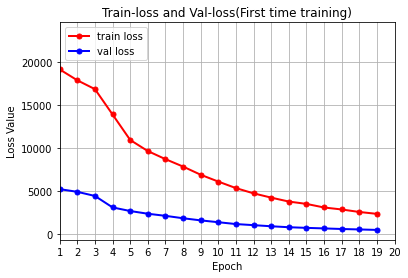

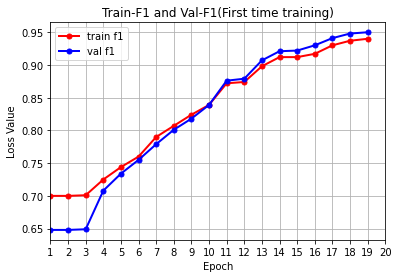

In [65]:
# First result of train loss and val loss

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
plt.figure(0)

train_loss = [23468.66, 19145.45, 17879.59, 16851.48, 13904.45, 10939.68, 9651.20, 8711.03, 7846.90, 6896.24, 6100.36, 
5342.08, 4732.81, 4234.11, 3777.41, 3505.42, 3088.97, 2857.67, 2566.01, 2347.08]
val_loss = [5770.96, 5219.54, 4909.61, 4428.18, 3095.42, 2676.06, 2361.55, 2116.44, 1836.57, 1589.17, 1374.37, 1160.77, 
           1033.30, 903.62, 792.23, 718.06, 654.42, 586.67, 533.76, 479.10]
plt.title('Train-loss and Val-loss(First time training)')
plt.plot(train_loss, label='train loss', linewidth=2, color='r', marker='o', markerfacecolor='r', markersize=5)
plt.plot(val_loss, label='val loss', linewidth=2, color='b', marker='o', markerfacecolor='b', markersize=5)
x_major_locator=MultipleLocator(1)
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
ax=plt.gca()
plt.grid()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(1,20)

plt.legend(loc='upper left')
plt.savefig("./loss_info_first.png")
plt.show()


train_f1= [0.700, 0.700, 0.700, 0.701,  0.725,  0.744, 0.760, 0.790, 0.807, 
                0.824, 0.839, 0.872, 0.874, 0.898, 0.912, 0.912, 0.917, 0.930, 0.937, 0.940]
val_f1 = [0.648, 0.648, 0.648, 0.649, 0.708,  0.734, 0.755, 0.779, 0.801, 0.818, 
          0.839, 0.876, 0.879, 0.907, 0.921, 0.922, 0.930, 0.941, 0.948, 0.950]

plt.title('Train-F1 and Val-F1(First time training)')
plt.plot(train_f1, label='train f1', linewidth=2, color='r', marker='o', markerfacecolor='r', markersize=5)
plt.plot(val_f1, label='val f1', linewidth=2, color='b', marker='o', markerfacecolor='b', markersize=5)
x_major_locator=MultipleLocator(1)
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
ax=plt.gca()
plt.grid()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(1,20)
plt.legend(loc='upper left')
plt.savefig("./f1_info_first.png")
plt.show()

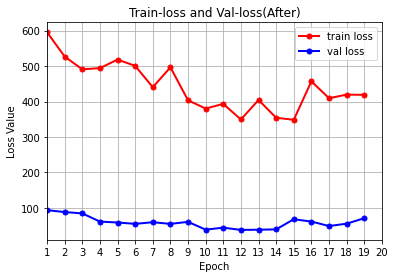

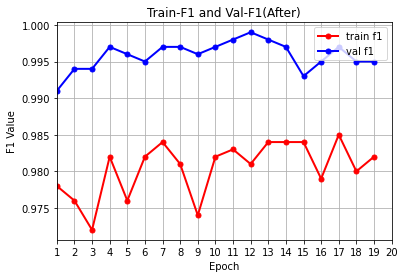

In [63]:
# After training
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

#train_loss and val_loss plot
plt.figure(0)
train_loss = [547.25, 595.23, 526.52, 490.71, 494.11, 518.11, 500.45, 440.34,496.33,
              403.40, 380.15, 393.22, 349.28, 404.25, 354.17, 348.42, 456.94, 409.21, 419.42, 418.70]
val_loss = [90.61,93.76, 88.33, 84.53, 61.49, 58.87, 55.11, 59.64,55.03, 60.73,
            38.79, 44.36, 38.01, 38.55, 39.57, 68.03, 61.59, 48.96,55.60,71.05]

plt.title('Train-loss and Val-loss(After)')
plt.plot(train_loss, label='train loss', linewidth=2, color='r', marker='o', markerfacecolor='r', markersize=5)
plt.plot(val_loss, label='val loss', linewidth=2, color='b', marker='o', markerfacecolor='b', markersize=5)
x_major_locator=MultipleLocator(1)
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
ax=plt.gca()
plt.grid()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(1,20)

plt.legend(loc='upper right')
plt.savefig("./loss_info.png")
plt.show()

# train_f1 score and val_loss score plot
plt.figure(1)
train_f1 = [0.976, 0.978, 0.976, 0.972, 0.982, 0.976, 0.982,0.984, 0.981,0.974,0.982, 
            0.983, 0.981, 0.984, 0.984, 0.984, 0.979,0.985, 0.980, 0.982]
val_f1 = [0.993,0.991, 0.994, 0.994, 0.997,0.996, 0.995, 0.997, 0.997, 0.996, 0.997, 
          0.998, 0.999, 0.998, 0.997, 0.993, 0.995, 0.997,0.995,0.995]
plt.title('Train-F1 and Val-F1(After)')
plt.plot(train_f1, label='train f1', linewidth=2, color='r', marker='o', markerfacecolor='r', markersize=5)
plt.plot(val_f1, label='val f1', linewidth=2, color='b', marker='o', markerfacecolor='b', markersize=5)
x_major_locator=MultipleLocator(1)
plt.xlabel('Epoch')
plt.ylabel('F1 Value')
ax=plt.gca()
plt.grid()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(1,20)
plt.legend(loc='upper right')
plt.savefig("./f1_info.png")
plt.show()


##Output result file

In [26]:
ix_2_tag={}
for x in tag_to_index.keys():
    ix_2_tag[tag_to_index[x]] = x


In [27]:

def predict(model, input_index):
    predicted=[]
    for x in input_index:
        input_tensor = torch.tensor(x).to(device)
        _, output = model(input_tensor)

        for i in output:
          predicted.append(ix_2_tag[i])
    return predicted

predition = predict(best_model, test_input_index)

In [67]:
# Output result csv file
model_result = range(len(predition))

test_predition = {'id':model_result,'Predicted':predition }
df = pd.DataFrame(test_predition)

df.to_csv('output.csv',index=False)
print("output file successfully!")

output file successfully!
